# Part 1: Sentiment Analysis on Corona-Tweets

### Imporing basic libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#To display plots inline; within the notebook window
%matplotlib inline

### Importing the dataset

In [2]:
dataset = pd.read_csv('Data/2020-03-28 Coronavirus Tweets.csv')

### Exploring Data

In [3]:
dataset.columns

Index(['status_id', 'user_id', 'created_at', 'screen_name', 'text', 'source',
       'reply_to_status_id', 'reply_to_user_id', 'reply_to_screen_name',
       'is_quote', 'is_retweet', 'favourites_count', 'retweet_count',
       'country_code', 'place_full_name', 'place_type', 'followers_count',
       'friends_count', 'account_lang', 'account_created_at', 'verified',
       'lang'],
      dtype='object')

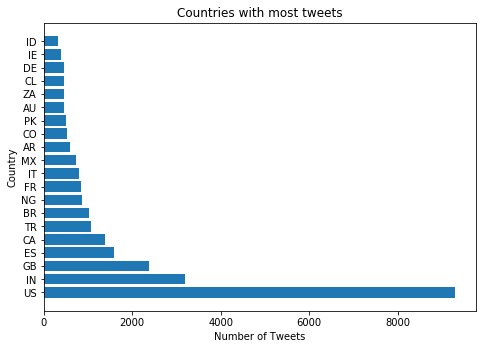

In [4]:
#Countries with most tweets

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# count the occurrence of each class 
data = dataset["country_code"].value_counts() 
# get x and y data 
points = data.index[:20]
frequency = data.values[:20]
#plot graph
ax.barh(points,frequency)
plt.title("Countries with most tweets")
plt.xlabel("Number of Tweets")
plt.ylabel("Country")
plt.show()


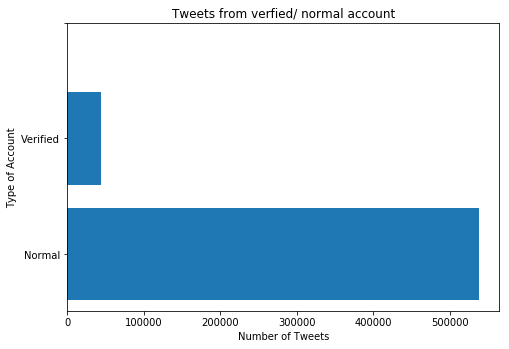

In [5]:
#Tweets from verfied/ normal account

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# count the occurrence of each class 
data = dataset["verified"].value_counts() 
# get x and y data 
points = data.index
frequency = data.values
#plot graph
ax.barh(points,frequency)
ax.set_yticks([0,1,2])
ax.set_yticklabels(["Normal","Verified"])
plt.xlabel("Number of Tweets")
plt.ylabel("Type of Account")
plt.title("Tweets from verfied/ normal account")
plt.show()

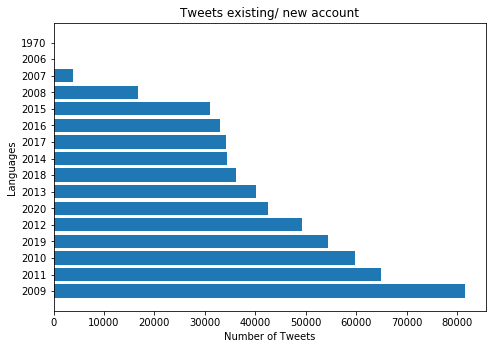

In [6]:
#Tweets existing/ new account

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# count the occurrence of each class 
temp_data = dataset.copy()
temp_data["account_created_at"] = [i[:4] for i in temp_data["account_created_at"]]
data = temp_data["account_created_at"].value_counts() 
# get x and y data 
points = data.index
frequency = data.values
#plot graph
ax.barh(points,frequency)
ax.set_yticklabels(data.index)
plt.xlabel("Number of Tweets")
plt.ylabel("Languages")
plt.title("Tweets existing/ new account")
plt.show()

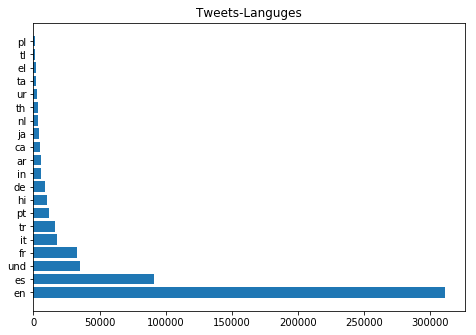

In [7]:
#Tweets-languages

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# count the occurrence of each class 
data = dataset["lang"].value_counts() 
# get x and y data 
points = data.index[:20]
frequency = data.values[:20]
#plot graph
ax.barh(points,frequency)
plt.title("Tweets-Languges")
plt.show()

### Importing necessary libraries for language processing

In [8]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt')
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gayatri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gayatri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Gayatri\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gayatri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Extract necessary columns from dataset

In [9]:
#Extracting English Tweets of all countries
tweets= dataset[["text","country_code"]][dataset['lang'] == 'en'].reset_index()
tweets.drop(["index"],axis=1)

#maintain a copy of original tweets before processing it
tweets_original = tweets.copy()

### Preprocess the data

In [10]:
#Retaining only alphabets (removing all punctuations and numbers)
tweets["text"] = [re.sub('[^a-zA-Z]', ' ',i) for i in tweets["text"]]

#Converting into lower case 
tweets["text"] = [i.lower() for i in tweets["text"]]

#Removing Emoticons
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')
tweets["text"]  = [deEmojify(i) for i in tweets["text"] ]


#Removing URLs
def removeURLs(str):
    ans = ""
    clean_tweet1 = re.match('(.*?)http.*?\s?(.*?)', str)
    clean_tweet2 = re.match('(.*?)https.*?\s?(.*?)', str)
    if clean_tweet1:
        ans=ans+clean_tweet1.group(1)
        ans=ans+clean_tweet1.group(2)
    elif clean_tweet2: 
        ans=ans+clean_tweet2.group(1)
        ans=ans+clean_tweet2.group(2)
    else:
        ans = str
    return ans


tweets["text"] = tweets["text"].apply(lambda tweet: removeURLs(tweet))


#Removing Stop Words
cachedStopWords = set(stopwords.words("english"))
tweets["text"] = tweets["text"].apply(lambda tweet: ' '.join([word for word in tweet.split() if word not in cachedStopWords]))

#Define words that we do not want to Stem or Lemmatize
specialWords = ["coronavirus", "covid","quarantine","coronavirusoutbreak","virus","corona","lockdown"]

#Stemming
ps = PorterStemmer()
def stemWords(word):
    if word in specialWords:
            return word
    else:
        return ps.stem(word)
        
tweets["text"] = tweets["text"].apply(lambda tweet: ' '.join([stemWords(word) for word in tweet.split()]))


#Lemmatization: 
wnl = WordNetLemmatizer()
def lemmatizeWords(word):
    if word in specialWords:
            return word
    else:
        return wnl.lemmatize(word)
tweets["text"] = tweets["text"].apply(lambda tweet: ' '.join([lemmatizeWords(word) for word in tweet.split()]))


#Preparing corpus
corpus=[]
corpus = [word for tweet in tweets["text"] for word in tweet.split()]

### Word Frequency Analysis

{'amp': 32961, 'case': 28028, 'coronalockdown': 17027, 'coronavirus': 133838, 'coronavirusoutbreak': 23282, 'covid': 228239, 'day': 18014, 'death': 17563, 'get': 19807, 'go': 16414, 'health': 11940, 'help': 18209, 'home': 17605, 'like': 16007, 'lockdown': 13563, 'make': 11773, 'need': 19010, 'new': 18432, 'one': 15859, 'pandem': 17225, 'peopl': 31447, 'plea': 12188, 'stay': 16708, 'take': 11982, 'test': 19287, 'time': 21205, 'trump': 12634, 'virus': 13081, 'work': 13733, 'world': 12965}


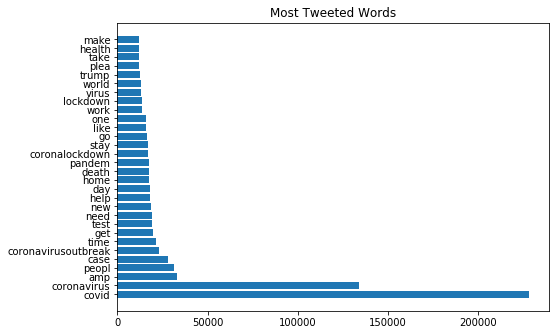

In [11]:
#Using Bag of Words
from operator import itemgetter  
vectorizer = CountVectorizer(max_features = 30)
cv = vectorizer.fit_transform(tweets["text"]).toarray()
terms = vectorizer.get_feature_names()
freqs = cv.sum(axis=0)
result = dict(zip(terms, freqs))
print(result)
features = []
vals = []
for key, value in sorted(result.items(), key = itemgetter(1), reverse = True):
    features.append(key)
    vals.append(value)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# get x and y data 
points = features
frequency = vals
#plot graph
ax.barh(points,frequency)
plt.title("Most Tweeted Words")
plt.show()

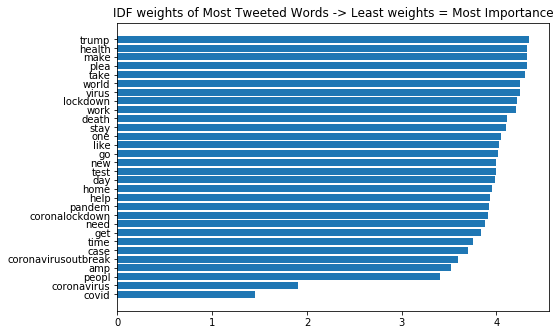

In [12]:
#Using Term Frequency (TF-IDF)

tf=TfidfTransformer(smooth_idf=True,use_idf=True)
tf.fit(cv)

# print idf values
data = { "Word" :vectorizer.get_feature_names(), "idf_weights":tf.idf_}
df_idf = pd.DataFrame(data)
 
# sort ascending
df_idf = df_idf.sort_values(by=['idf_weights'])


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# get x and y data 
points = df_idf["Word"]
frequency = df_idf["idf_weights"]
#plot graph
ax.barh(points,frequency)
plt.title("IDF weights of Most Tweeted Words -> Least weights = Most Importance")
plt.show()



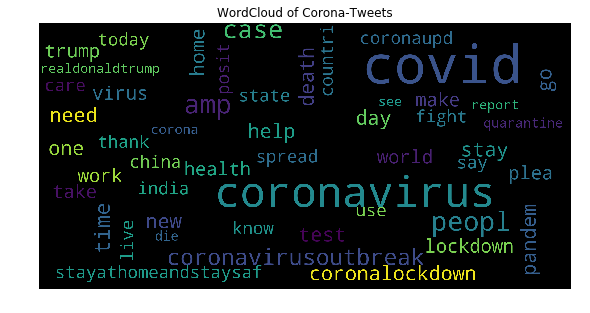

In [13]:
wordcloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(corpus))
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor="None") 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title("WordCloud of Corona-Tweets")
plt.tight_layout(pad = 0) 
plt.show()

### Sentiment Analysis

In [14]:
s = SentimentIntensityAnalyzer()
scores = tweets["text"].apply(lambda tweet: s.polarity_scores(tweet))
scores_df = pd.DataFrame(list(scores))
scores_df.head()

,compound,neg,neu,pos
0,0.0000,0.000,1.000,0.000
1,0.2023,0.185,0.543,0.272
2,0.0000,0.000,1.000,0.000
3,-0.0516,0.173,0.619,0.208
4,0.0000,0.000,1.000,0.000


In [15]:
#Calculating sentiments for all tweets
scores_df['result'] = scores_df['compound'].apply(lambda res: 'neutral' if res == 0 else ('positive' if res > 0 else 'negative'))
scores_df['tweet'] = tweets_original["text"]
scores_df["country_code"] = tweets_original["country_code"]
scores_df= scores_df.sort_values(by=['compound'])


#Calculating sentiments wrt top 5 tweeting countries
us = scores_df[["tweet","result","country_code"]][scores_df.country_code == 'US']
us_positive = us[["tweet","result","country_code"]][us.result == 'positive']
score_us_positive = us_positive.shape[0]
us_negative = us[["tweet","result","country_code"]][us.result == 'negative']
score_us_negative = us_negative.shape[0]
us_neutral = us[["tweet","result","country_code"]][us.result == 'neutral']
score_us_neutral = us_neutral.shape[0]

india = scores_df[["tweet","result","country_code"]][scores_df.country_code == 'IN']
india_positive = india[["tweet","result","country_code"]][india.result == 'positive']
score_india_positive = india_positive.shape[0]
india_negative = india[["tweet","result","country_code"]][india.result == 'negative']
score_india_negative = india_negative.shape[0]
india_neutral = india[["tweet","result","country_code"]][india.result == 'neutral']
score_india_neutral = india_neutral.shape[0]

uk = scores_df[["tweet","result","country_code"]][scores_df.country_code == 'GB']
uk_positive = uk[["tweet","result","country_code"]][uk.result == 'positive']
score_uk_positive = uk_positive.shape[0]
uk_negative = uk[["tweet","result","country_code"]][uk.result == 'negative']
score_uk_negative = uk_negative.shape[0]
uk_neutral = uk[["tweet","result","country_code"]][uk.result == 'neutral']
score_uk_neutral = uk_neutral.shape[0]

spain = scores_df[["tweet","result","country_code"]][scores_df.country_code == 'ES']
spain_positive = spain[["tweet","result","country_code"]][spain.result == 'positive']
score_spain_positive = spain_positive.shape[0]
spain_negative = spain[["tweet","result","country_code"]][spain.result == 'negative']
score_spain_negative = spain_negative.shape[0]
spain_neutral = spain[["tweet","result","country_code"]][spain.result == 'neutral']
score_spain_neutral = spain_neutral.shape[0]

canada = scores_df[["tweet","result","country_code"]][scores_df.country_code == 'CA']
canada_positive = canada[["tweet","result","country_code"]][canada.result == 'positive']
score_canada_positive = canada_positive.shape[0]
canada_negative = canada[["tweet","result","country_code"]][canada.result == 'negative']
score_canada_negative = canada_negative.shape[0]
canada_neutral = canada[["tweet","result","country_code"]][canada.result == 'neutral']
score_canada_neutral = canada_neutral.shape[0]

### Sentiment Analysis of Tweets around the world

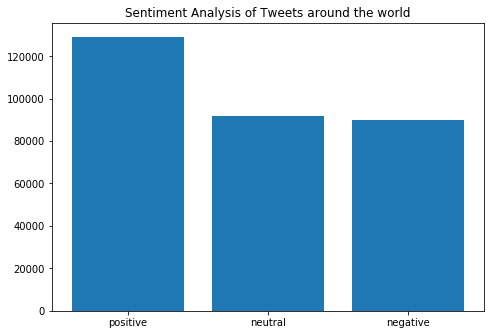

In [16]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
data = scores_df["result"].value_counts()
# get x and y data 
points = data.index
frequency = data.values
#plot graph
ax.bar(points,frequency)
plt.title("Sentiment Analysis of Tweets around the world")
plt.show()

### Sentiment Analysis in top 5 tweeting countries

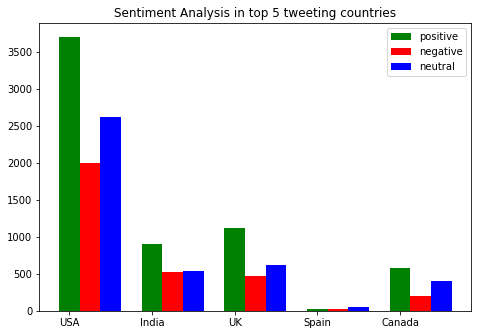

In [17]:
data = [[score_us_positive,score_india_positive, score_uk_positive, score_spain_positive, score_canada_positive],
[score_us_negative,score_india_negative, score_uk_negative, score_spain_negative, score_canada_negative],
[score_us_neutral,score_india_neutral, score_uk_neutral, score_spain_neutral, score_canada_neutral]]
X = np.arange(5)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(["USA","India","UK","Spain","Canada"])
ax.bar(X + 0.00, data[0], color = 'g', width = 0.25, label="positive")
ax.bar(X + 0.25, data[1], color = 'r', width = 0.25, label="negative")
ax.bar(X + 0.50, data[2], color = 'b', width = 0.25, label="neutral")
plt.title("Sentiment Analysis in top 5 tweeting countries")
plt.legend(loc="upper right")
plt.show()

In [18]:
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]
pos_word_weight=[]
neu_word_weight=[]
neg_word_weight=[]

def get_word_sentiment(text):
    
    tokenized_text = nltk.word_tokenize(text)
    #print(tokenized_text)    

    for word in tokenized_text:
            if (s.polarity_scores(word)['compound']) >= 0.6:
                pos_word_list.append(word)
                pos_word_weight.append(s.polarity_scores(word)['compound'])
            elif (s.polarity_scores(word)['compound']) <= -0.6:
                neg_word_list.append(word)
                neg_word_weight.append(s.polarity_scores(word)['compound'])
            else:
                neu_word_list.append(word)
                neu_word_weight.append(s.polarity_scores(word)['compound'])

for tweet in tweets["text"]:
    get_word_sentiment(tweet)


In [19]:
print('Total Positive Words in Tweets:',len(pos_word_list))
print('Total Negative Words in Tweets:',len(neg_word_list))
print('Total Neutral Words in Tweets:',len(neu_word_list)) 

Total Positive Words in Tweets: 16459
Total Negative Words in Tweets: 11410
Total Neutral Words in Tweets: 4692731


In [20]:
pos_word_list = list(set(pos_word_list))
neg_word_list = list(set(neg_word_list))
neu_word_list = list(set(neu_word_list))

result_pos = dict(zip(pos_word_list, pos_word_weight))
result_neg = dict(zip(neg_word_list, neg_word_weight))
result_neu = dict(zip(neu_word_list, neu_word_weight))

features_pos = []
vals_pos = []

features_neg = []
vals_neg = []

features_neu = []
vals_neu = []

for key, value in sorted(result_pos.items(), key = itemgetter(1), reverse = True):
    features_pos.append(key)
    vals_pos.append(value)
for key, value in sorted(result_neg.items(), key = itemgetter(1), reverse = True):
    features_neg.append(key)
    vals_neg.append(value)
for key, value in sorted(result_neu.items(), key = itemgetter(1), reverse = True):
    features_neu.append(key)
    vals_neu.append(value)

top_positive_words = features_pos[:10]
top_positive_words_freq = vals_pos[:10]

top_negative_words = features_neg[:10]
top_negative_words_freq = vals_neg[:10]

top_neutral_words = features_neu[:10]
top_neutral_words_freq = vals_neu[:10]


print(top_positive_words)
print(top_negative_words)
print(top_neutral_words)


['glee', 'best', 'great', 'glorious', 'brightest', 'superb', 'freedom', 'greatest', 'amor', 'splendor']
['scumbag', 'murder', 'shithead', 'douchebag', 'killing', 'hell', 'disaster', 'saddest', 'dx', 'dickhead']
['rotoflex', 'unicefphil', 'youareexpectedtolead', 'kgmu', 'theinvisiblemanathom', 'belgray', 'sukkar', 'kelvinnatembea', 'thingsmygrandparentstaughtm', 'improperli']


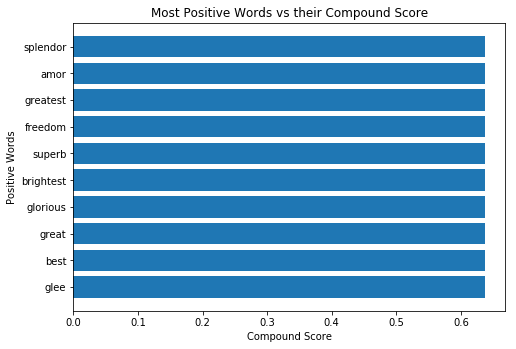

In [21]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# get x and y data 
points = top_positive_words
frequency = top_positive_words_freq
#plot graph
ax.barh(points,frequency)
plt.title("Most Positive Words vs their Compound Score")
plt.xlabel("Compound Score")
plt.ylabel("Positive Words")
plt.show()

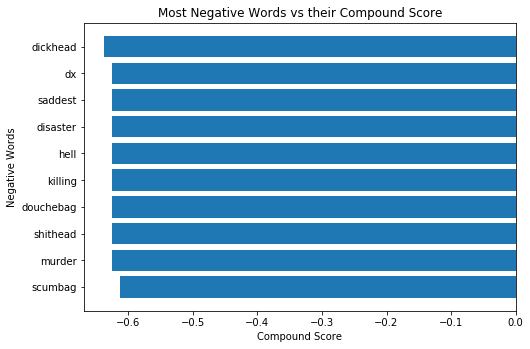

In [22]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# get x and y data 
points = top_negative_words
frequency = top_negative_words_freq
#plot graph
ax.barh(points,frequency)
plt.title("Most Negative Words vs their Compound Score")
plt.xlabel("Compound Score")
plt.ylabel("Negative Words")
plt.show()

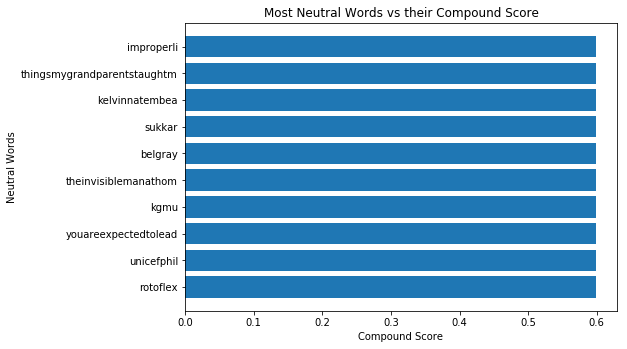

In [23]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# get x and y data 
points = top_neutral_words
frequency = top_neutral_words_freq
#plot graph
ax.barh(points,frequency)
plt.title("Most Neutral Words vs their Compound Score")
plt.xlabel("Compound Score")
plt.ylabel("Neutral Words")
plt.show()

# Part 2: WHO Corona-Tweets Summarization

### Importing the Dataset

In [24]:
who_dataset = pd.read_csv('Data/WHO__tweet_data.csv')
who_dataset.head()

,User,Date,Tweet,Binders,Permalink,Retweet count,Likes count,Tweet value
0,World Health Organization (WHO),7/4/2020 20:54:39,"During #COVID19, masks should be used as part ...",NaN,https://www.twitter.com/user/status/1247628881...,52,113,2684.28
1,World Health Organization (WHO),7/4/2020 20:54:29,"In the community during #COVID19, we recommend...",NaN,https://www.twitter.com/user/status/1247628839...,51,118,2684.28
2,World Health Organization (WHO),7/4/2020 20:54:20,"In health care facilities during #COVID19, WHO...",NaN,https://www.twitter.com/user/status/1247628799...,22,44,2684.28
3,World Health Organization (WHO),7/4/2020 20:54:08,We encourage countries that are considering th...,NaN,https://www.twitter.com/user/status/1247628751...,35,86,2440.25
4,World Health Organization (WHO),7/4/2020 20:53:55,"If masks are worn, they must be used safely an...",NaN,https://www.twitter.com/user/status/1247628697...,93,169,2928.30


### Preprocessing the Data

In [25]:
#Retaining only alphabetnumerics
who_dataset["Tweet"] = [re.sub('[^a-zA-Z0-9]', ' ',i) for i in who_dataset["Tweet"]]

#Converting into lower case 
who_dataset["Tweet"] = [i.lower() for i in who_dataset["Tweet"]]

#Removing Emoticons
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')
who_dataset["Tweet"]  = [deEmojify(i) for i in who_dataset["Tweet"]]

#Removing URLs
def removeURLs(str):
    ans = ""
    clean_tweet1 = re.match('(.*?)http.*?\s?(.*?)', str)
    clean_tweet2 = re.match('(.*?)https.*?\s?(.*?)', str)
    if clean_tweet1:
        ans=ans+clean_tweet1.group(1)
        ans=ans+clean_tweet1.group(2)
    elif clean_tweet2: 
        ans=ans+clean_tweet2.group(1)
        ans=ans+clean_tweet2.group(2)
    else:
        ans = str
    return ans
who_dataset["Tweet"] = who_dataset["Tweet"].apply(lambda tweet: removeURLs(tweet))


sentences = [i for i in who_dataset["Tweet"]]

### Create the word frequency table

In [26]:
#Create a word frequency table from every sentence.

def create_frequency_table(text_string) -> dict:
    
    #Remove all the stop words
    stopWords = set(stopwords.words("english"))
    #Tokenise the sentence into words
    words = word_tokenize(text_string)
    #Stem the words to get the root word
    ps = PorterStemmer()
    
    freqTable = dict()
    for word in words:
        word = ps.stem(word)
        if word in stopWords:
            continue
        if word in freqTable:
            freqTable[word] += 1
        else:
            freqTable[word] = 1

    return freqTable

### Term Frequency Method

In [27]:
#Score a sentence by its words, adding the frequency of every non-stop word in a sentence.
#First 10 chars of each sentence is used as key instead of using whole sentence; to prevent memory overload.

def score_sentences(sentences, freqTable) -> dict:
    
    sentenceValue = dict()

    for sentence in sentences:
        word_count_in_sentence = (len(word_tokenize(sentence)))
        for word in freqTable:
            if word in sentence:
                if sentence[:10] in sentenceValue:
                    sentenceValue[sentence[:10]] += freqTable[word]
                else:
                    sentenceValue[sentence[:10]] = freqTable[word]

        #To prevent large sentences from dominating, we divide the score of a sentences by total number of words in it
        if word_count_in_sentence > 0:
            sentenceValue[sentence[:10]] = sentenceValue[sentence[:10]] // word_count_in_sentence

    return sentenceValue

### Find the Threshold Score

In [28]:
#Consider the average score of the sentences as a threshold

def find_average_score(sentenceValue) -> int:
    sumValues = 0
    for entry in sentenceValue:
        sumValues += sentenceValue[entry]

    # Average value of a sentence from original text
    average = int(sumValues / len(sentenceValue))

    return average

### Generate Summary

In [29]:
#Select a sentence for summarization, only if the sentence score is more than the threshold score

def generate_summary(sentences, sentenceValue, threshold):
    sentence_count = 0
    summary = []

    for sentence in sentences:
        if sentence[:10] in sentenceValue and sentenceValue[sentence[:10]] > (threshold):
            summary.append(sentence)
            sentence_count += 1

    return summary

### Driver Function for WHO corona-tweet summarizarion

In [30]:
# 1 Create the word frequency table
freq_table = create_frequency_table('. '.join(sentences))

# 2 Important Algorithm: score the sentences
sentence_scores = score_sentences(sentences, freq_table)

# 3 Find the threshold
threshold = find_average_score(sentence_scores)

# 4 Important Algorithm: Generate the summary
summary = generate_summary(sentences, sentence_scores, 1.5 * threshold)

#5 ignore repetitive sentences in summary
countSummary = 0
summaryText = []
for i in summary:
    if(summary.count(i)==1):
        #Trimming extra white spaces
        i = re.sub(' +', ' ', i)
        
        countSummary+=1
        summaryText.append(i)
        
        print(str(countSummary)+")  "+i+"\n")


1)   more than 3 000 healthworkers have been infected amp many have paid the ultimate price when health workers are exposed or become sick they have to go home amp stay there for at least 2 weeks hospitals scramble to find replacements drtedros thankshealthheroes worldhealthday

2)   thankshealthheroes 

3)   more than 70 countries have joined who s solidarity trial to accelerate the search for an effective treatment and about 20 institutions amp companies are racing to develop a vaccine drtedros covid19 coronavirus

4)   we encourage countries that are considering the use of masks for the general population to study their effectiveness so we can all learn most importantly masks should only ever be used as part of a comprehensive package of interventions drtedros covid19 coronavirus

5)   in health care facilities who continues to recommend the use of medical masks respirators amp other personal protective equipment for healthworkers drtedros covid19

6)   we understand that some count

In [31]:
print("Number of Tweets by WHO: "+str(len(sentences)))
print("Number of Sentences in Summary: "+str(countSummary))

Number of Tweets by WHO: 2290
Number of Sentences in Summary: 238
